In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, ttest_ind
from itertools import groupby
import matplotlib.pyplot as plt

In [15]:
!which python

/home/aalag/anaconda3/bin/python


In [16]:
def get_member_ratio(datadf, metrics, thre_cnt=1, skip=[], mode='ks'):
    sample2mem = []
    for idx, row in datadf.iterrows():
        sample2mem.append(np.sum([row[m] for m in (set(metrics) - set(skip))]))
    
    members_bool = np.asarray(sample2mem) >= thre_cnt

    if mode == 'ks': # ks distance
        _, pvalue = ks_2samp(members_bool,[1 for i in range(10000)] , mode='asymp')
    elif mode == 't': # majority
        if members_bool.mean() == 1:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
    elif mode == 'max':
        if max(members_bool) == 1:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
    elif mode == 'majority':
        if members_bool.sum() > members_bool.size // 2:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
         

    return np.sum(members_bool) / len(datadf), pvalue

In [17]:
!pwd

/della/scratch/gpfs/aalag/DataAuditingThesis


In [18]:
class TableObj:
    def __init__(self, table, expt, mode, size, data):
        self.table = table
        self.expt = expt
        self.mode = mode
        self.size = size
        self.data = data

In [19]:
def compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup):
    tables = []
    EMA_res_table = pd.DataFrame(columns=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'SVHN'], index=[f'k={100-k}' for k in klist])
    for expt in experiments:
        for caldata in data:
            for size in sizes:
                for mode in modes:
                    print(f'-----  Query_size:{size} \t Cal data:{caldata}  -----')
                    for k in klist:
                        logname = f'caldata={caldata}_epoch={epoch}_k={k}_calsize=10000'
                        for fold in range(7):
                            queryset = pd.read_csv(f'./saves_new/{expt}/EMA_{caldata}/query_set/binarized_{logname}_fold{fold}.csv')  
                            if fold == 0 or fold == 6:
                                ground_truth = 'Query is not in base'
                            else:
                                ground_truth = 'Query is in base'
                            t, pv = get_member_ratio(queryset[:size], metrics, mode=mode)

                            EMA_res = np.around(pv, decimals=2)
                            if fold == 0:
                                EMA_res_table['SVHN'][f'k={100-k}'] = EMA_res
                            else:
                                EMA_res_table[f'M{fold}'][f'k={100-k}'] = EMA_res

                    if expt == "":
                        table_obj = TableObj(EMA_res_table, "Control EMA", mode, size, caldata)
                    else:
                        table_obj = TableObj(EMA_res_table, expt, mode, size, caldata)
                    tables.append(table_obj)
                    print(EMA_res_table, '\n')
                    EMA_res_table = pd.DataFrame(columns=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'SVHN'], index=[f'k={100-k}' for k in klist])

    return tables

In [20]:
### Run EMA on the benchmark datasets, Table 2.b and Table 6
experiments = ["", "re-dropout0.1", "re-dropout0.2", "re-dropout0.3", "re-dropout0.4", "re-dropout0.5", "re-dropout0.6","re-dropout0.7","re-dropout0.8", "re-dropout0.9", "re-plateau1"]
epoch = 50

metrics = ['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits']

klist = [0, 10, 20, 30, 40, 50]
sizes = [2000, 500, 200, 50, 20, 5]
data = ['MNIST']
mixup = False
modes = ['t']

# tables = compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup)

In [21]:
tables_plateau = compute_tables(["", "re-plateau20", "re-plateau10", "re-plateau5", "re-plateau1"], data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5 M6 SVHN
k=100  1  1  1  1  1  0    0
k=90   1  1  1  1  1  0    0
k=80   1  1  1  1  1  0    0
k=70   1  1  1  1  1  0    0
k=60   1  1  1  1  1  0    0
k=50   1  1  1  1  1  0    0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5 M6 SVHN
k=100  1  1  1  1  1  0    0
k=90   1  1  1  1  1  0    0
k=80   1  1  1  1  1  0    0
k=70   1  1  1  1  1  0    0
k=60   1  1  1  1  1  0    0
k=50   1  1  1  1  1  0    0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.04    0
k=90   1  1  1  1  1  0.01    0
k=80   1  1  1  1  1  0.08    0
k=70   1  1  1  1  1  0.16    0
k=60   1  1  1  1  1  0.02    0
k=50   1  1  1  1  1  0.01    0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1     1    0
k=90   1  1  1  1  1     1    0
k=80   1  1  1  1  1  0.16    0
k=70   1  1  1  1  1  0.32    0
k=60   1  1  1  1  1

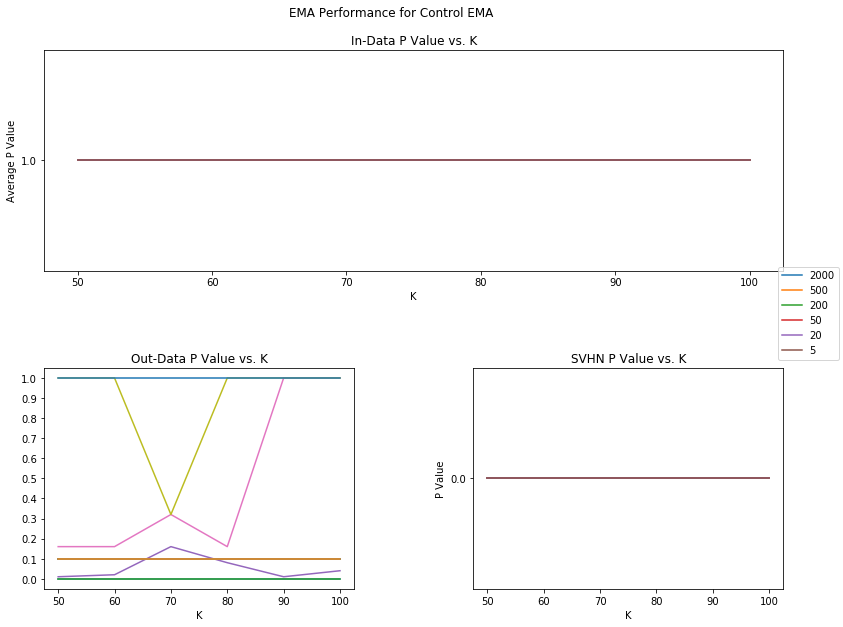

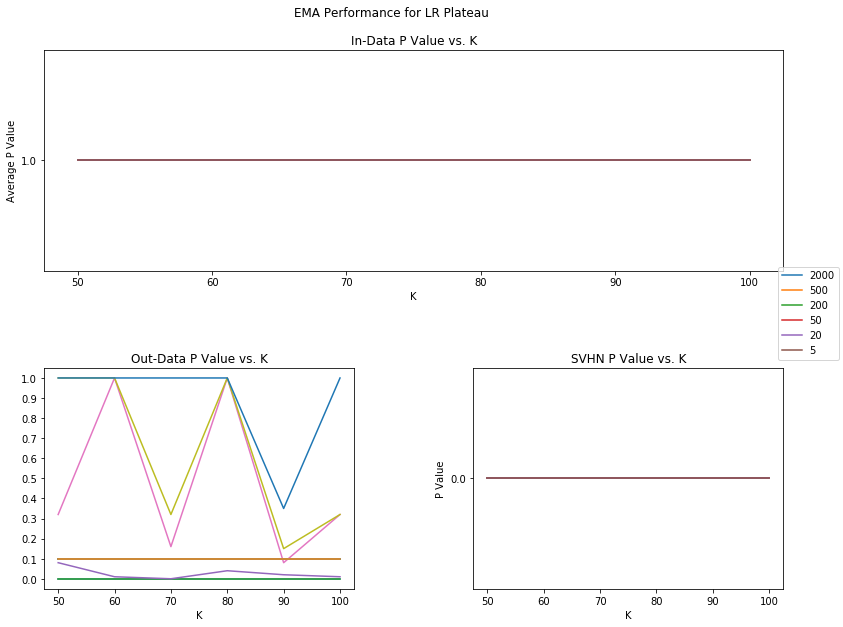

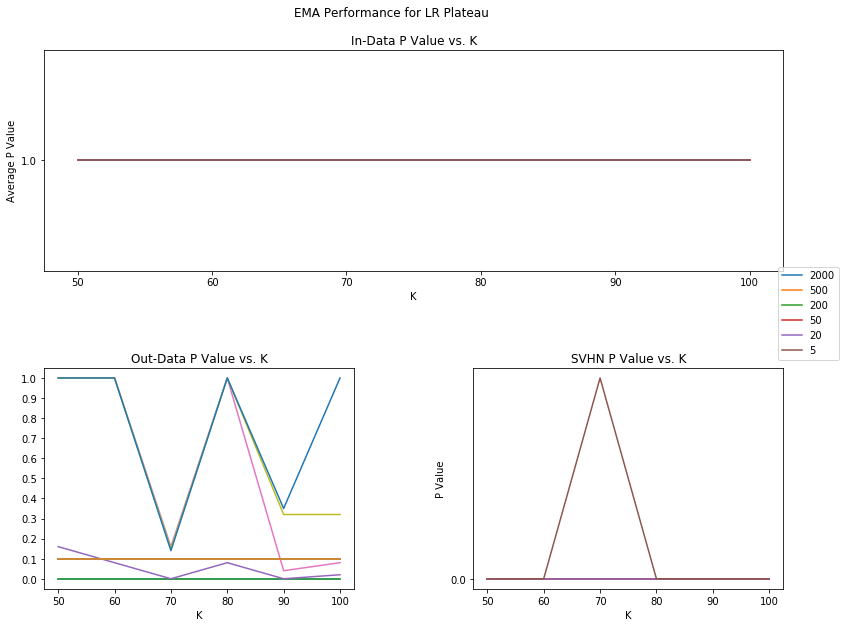

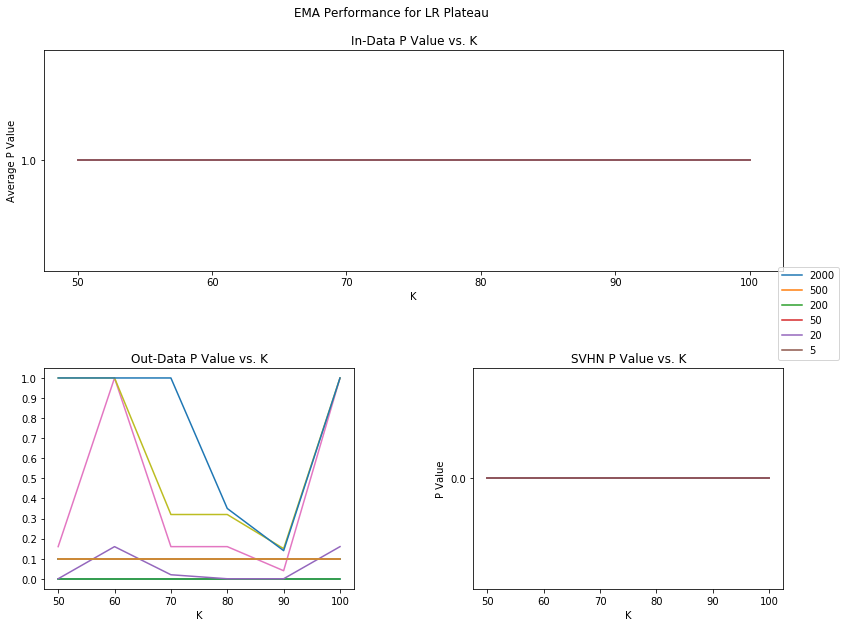

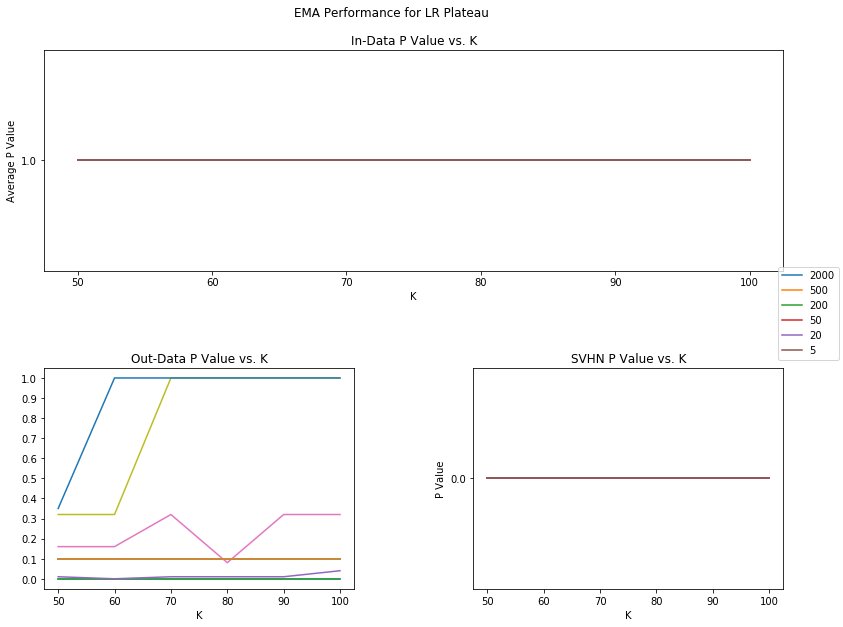

NameError: name 'graph_200' is not defined

In [22]:
graph_tables(tables_plateau)
graph_200(tables_plateau, 200, 5)

In [27]:
def graph_tables(tables):
    # separate line for each query size, two graphs per experiment
    # average M1 - M5 vs M6, SVHN for each k, plot against k
    for expt, group in groupby(tables, key = lambda x: x.expt):
        fig = plt.figure()
        ax1 = plt.subplot(2, 2, (1, 2))
        ax2 = plt.subplot(2, 2, 3)
        ax3 = plt.subplot(2, 2, 4)
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12.5, 9.5)
        if "re-dropout" in expt:
            expt_string = "Dropout: " + expt.strip("re-dropout")
        elif "re-plateau" in expt:
            expt_string = "LR Plateau"
        else:
            expt_string = expt
            
        fig.suptitle("EMA Performance for " + expt_string)
        ax1.set_xlabel("K")
        ax1.set_ylabel("Average P Value")
        ax1.set_title("In-Data P Value vs. K")
        ax2.set_xlabel("K")
        ax2.set_title("Out-Data P Value vs. K")
        ax3.set_title("SVHN P Value vs. K")
        ax3.set_xlabel("K")
        ax3.set_ylabel("P Value")
        for ax in [ax1, ax2, ax3]:
            ax.set_yticks(np.arange(0, 1.01, 0.1))
        for size_table in group:
            table = size_table.table
            size = size_table.size
            ks = []
            ins = []
            outs = []
            svhns = []
            for index, row in table.iterrows():
                k_val = int(index.strip("k="))
                in_data = list(row[['M1', 'M2', 'M3', 'M4', 'M5']])
                out_data = row['M6']
                svhn = row['SVHN']
                ks.append(k_val)
                ins.append(np.mean(in_data))
                outs.append(out_data)
                svhns.append(svhn)
            ax1.plot(ks, ins, label=size)
            ax2.plot(ks, outs, label=size)
            ax3.plot(ks, svhns, label=size)
        ax2.plot(ks, [0.1]*len(ks), 'r--', label="threshold")
            
        lines = []
        labels = []

        Line, Label = ax2.get_legend_handles_labels()
        # print(Label)
        lines.extend(Line)
        labels.extend(Label)

        fig.legend(lines, labels, loc='center right')

        if "re-dropout" in expt:
            save_str = "Dropout" + expt.strip("re-dropout") + ".png"
        else:
            save_str = expt_string + ".png"
            
        plt.savefig(save_str, format="png", dpi="figure")
        plt.show()
        plt.close()

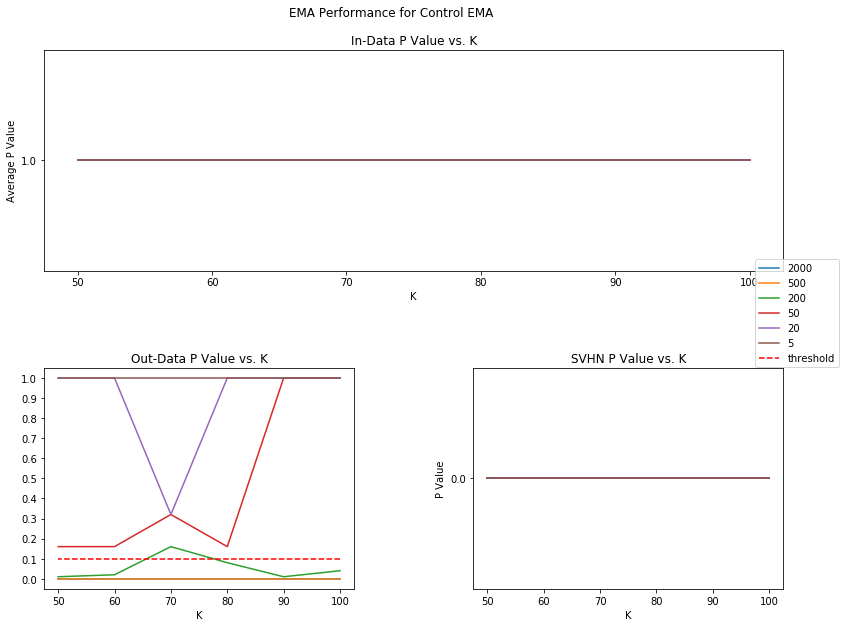

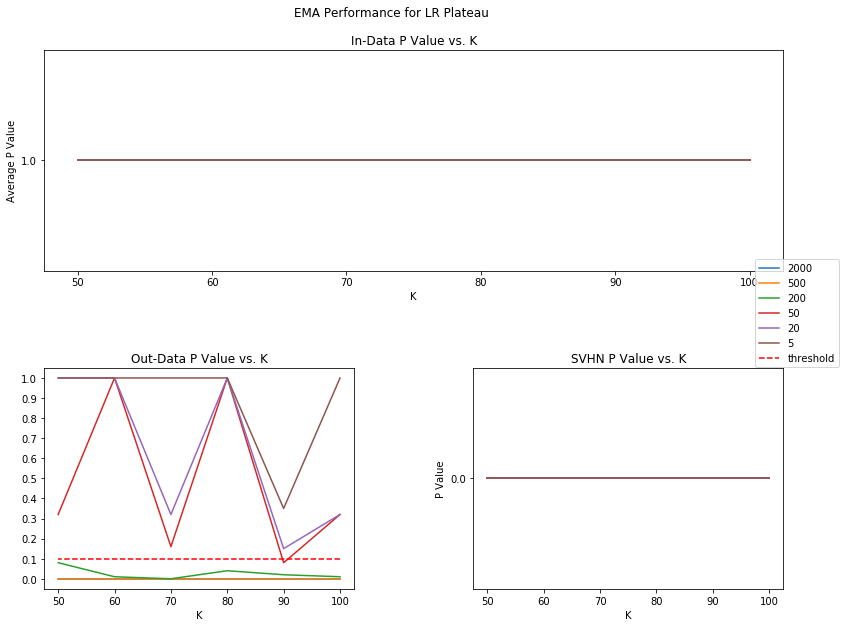

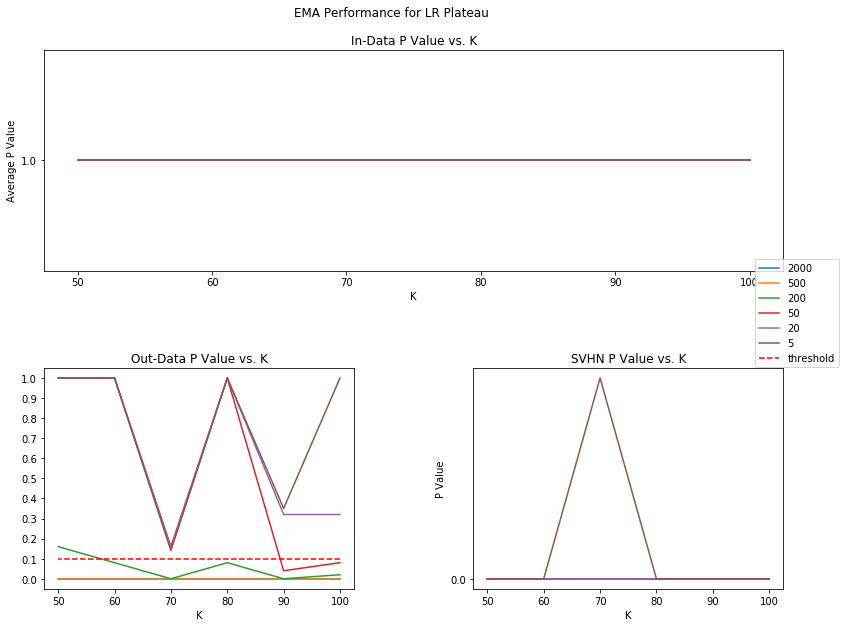

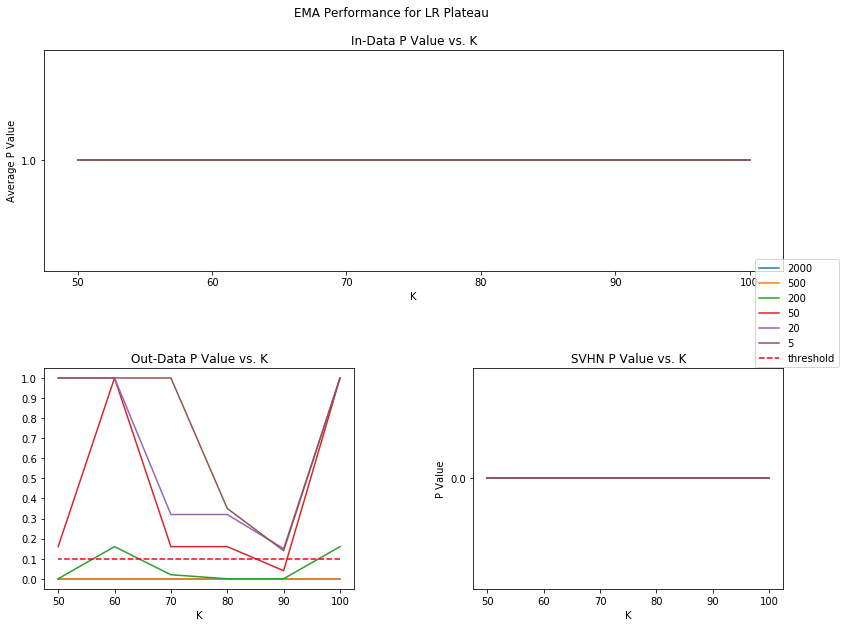

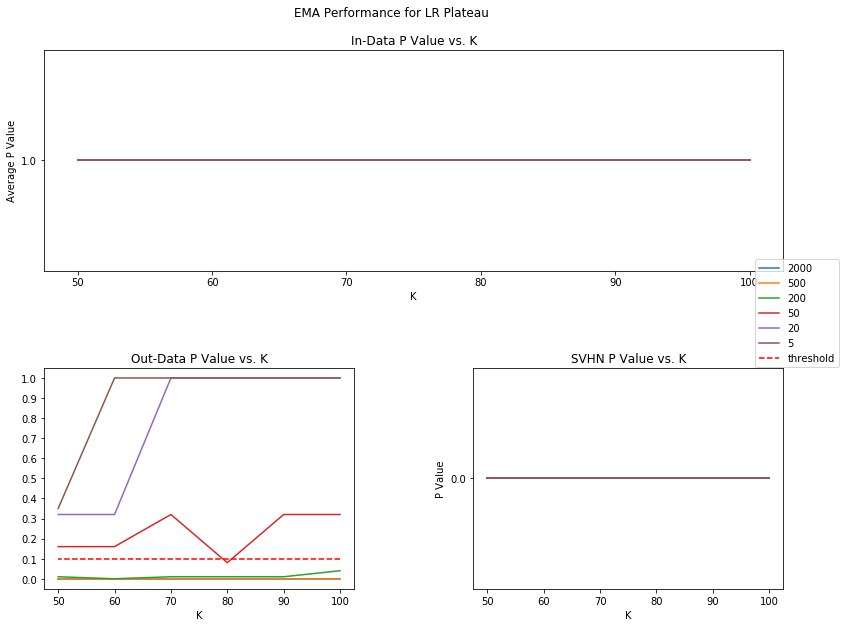

In [28]:
graph_tables(tables_plateau)

In [59]:
def ema_accuracy(tables):
    for table in tables:
        tab = table.table
        in_avg = 0
        for col in ['M1', 'M2', 'M3', 'M4', 'M5']:
            in_avg += sum(tab[col])/len(tab[col])
        
        col = 'M6'
        m6_avg = sum(tab[col])/len(tab[col])
        
        col = 'SVHN'
        svhn_avg = sum(tab[col])/len(tab[col])
        total = in_avg/5 + (1 - m6_avg) + (1 - svhn_avg)
        total /= .03
        print(table.expt, table.size, total)

In [61]:
tab_drop = compute_tables(["", "re-dropout0.1", "re-dropout0.2", "re-dropout0.3", "re-dropout0.4", "re-dropout0.5", "re-dropout0.6", "re-dropout0.7", "re-dropout0.8", "re-dropout0.9"], data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5 M6 SVHN
k=100  1  1  1  1  1  0    0
k=90   1  1  1  1  1  0    0
k=80   1  1  1  1  1  0    0
k=70   1  1  1  1  1  0    0
k=60   1  1  1  1  1  0    0
k=50   1  1  1  1  1  0    0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5 M6 SVHN
k=100  1  1  1  1  1  0    0
k=90   1  1  1  1  1  0    0
k=80   1  1  1  1  1  0    0
k=70   1  1  1  1  1  0    0
k=60   1  1  1  1  1  0    0
k=50   1  1  1  1  1  0    0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.04    0
k=90   1  1  1  1  1  0.01    0
k=80   1  1  1  1  1  0.08    0
k=70   1  1  1  1  1  0.16    0
k=60   1  1  1  1  1  0.02    0
k=50   1  1  1  1  1  0.01    0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1     1    0
k=90   1  1  1  1  1     1    0
k=80   1  1  1  1  1  0.16    0
k=70   1  1  1  1  1  0.32    0
k=60   1  1  1  1  1

      M1    M2    M3 M4 M5 M6 SVHN
k=100  1  0.32  0.32  1  1  0    0
k=90   1     1     1  1  1  0    0
k=80   1     1     1  1  1  0    0
k=70   1  0.16  0.32  1  1  0    0
k=60   1  0.32     1  1  1  0    0
k=50   1  0.32     1  1  1  0    0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1    M2    M3 M4 M5    M6 SVHN
k=100  1     1  0.32  1  1  0.08    0
k=90   1     1     1  1  1  0.01    0
k=80   1     1     1  1  1  0.01    0
k=70   1     1     1  1  1  0.04    0
k=60   1     1     1  1  1  0.04    0
k=50   1  0.32     1  1  1  0.02    0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1    M2 M3 M4 M5    M6 SVHN
k=100  1     1  1  1  1     1    0
k=90   1     1  1  1  1  0.16    0
k=80   1     1  1  1  1  0.32    0
k=70   1     1  1  1  1     1    0
k=60   1     1  1  1  1  0.32    0
k=50   1  0.32  1  1  1  0.16    0 

-----  Query_size:20 	 Cal data:MNIST  -----
      M1    M2 M3 M4 M5    M6 SVHN
k=100  1     1  1  1  1     1    0
k=90   1     1  1  1  1     1   

         M1    M2    M3    M4    M5    M6 SVHN
k=100  0.35  0.35  0.04     1     1     1    0
k=90      1     1     1  0.35     1  0.14    0
k=80      1     1     1  0.35     1  0.35    0
k=70      1  0.35  0.35  0.35  0.35     1    0
k=60      1     1     1  0.35     1     1    0
k=50   0.35     1  0.35  0.14     1     1    0 



In [62]:
ema_accuracy(tab_drop)

Control EMA 2000 100.0
Control EMA 500 100.0
Control EMA 200 98.22222222222223
Control EMA 50 84.44444444444444
Control EMA 20 70.44444444444444
Control EMA 5 66.66666666666667
re-dropout0.1 2000 90.93333333333332
re-dropout0.1 500 98.4888888888889
re-dropout0.1 200 96.74444444444445
re-dropout0.1 50 83.68888888888888
re-dropout0.1 20 73.46666666666667
re-dropout0.1 5 70.27777777777779
re-dropout0.2 2000 100.0
re-dropout0.2 500 100.0
re-dropout0.2 200 98.27777777777779
re-dropout0.2 50 85.33333333333334
re-dropout0.2 20 78.0
re-dropout0.2 5 70.05555555555556
re-dropout0.3 2000 100.0
re-dropout0.3 500 100.0
re-dropout0.3 200 99.66666666666667
re-dropout0.3 50 84.33333333333334
re-dropout0.3 20 70.44444444444444
re-dropout0.3 5 66.44444444444444
re-dropout0.4 2000 100.0
re-dropout0.4 500 100.0
re-dropout0.4 200 97.5
re-dropout0.4 50 74.22222222222223
re-dropout0.4 20 70.44444444444444
re-dropout0.4 5 66.66666666666667
re-dropout0.5 2000 85.33333333333334
re-dropout0.5 500 95.288888888888

In [60]:
ema_accuracy(tables_plateau)

Control EMA 2000 100.0
Control EMA 500 100.0
Control EMA 200 98.22222222222223
Control EMA 50 84.44444444444444
Control EMA 20 70.44444444444444
Control EMA 5 66.66666666666667
re-plateau20 2000 100.0
re-plateau20 500 100.0
re-plateau20 200 99.11111111111113
re-plateau20 50 84.0
re-plateau20 20 78.94444444444444
re-plateau20 5 70.27777777777779
re-plateau10 2000 100.0
re-plateau10 500 100.0
re-plateau10 200 98.11111111111111
re-plateau10 50 81.77777777777777
re-plateau10 20 78.94444444444444
re-plateau10 5 74.83333333333333
re-plateau5 2000 100.0
re-plateau5 500 100.0
re-plateau5 200 98.11111111111111
re-plateau5 50 86.0
re-plateau5 20 78.94444444444444
re-plateau5 5 75.05555555555556
re-plateau1 2000 100.0
re-plateau1 500 100.0
re-plateau1 200 99.55555555555556
re-plateau1 50 92.44444444444446
re-plateau1 20 74.22222222222223
re-plateau1 5 70.27777777777779


In [38]:
def graph_200(tables, filter_size=200, NUM_COLORS=11):
    # three graphs (in, out, svhn) one line per experiment at size = 200 vs K
    fig = plt.figure()
    ax1 = plt.subplot(2, 2, (1, 2))
    ax2 = plt.subplot(2, 2, 3)
    ax3 = plt.subplot(2, 2, 4)
    filtered = filter(lambda table: table.size == filter_size, tables)
    fig.tight_layout(pad=2.0)
    fig.set_size_inches(12.5, 9.5)

    if NUM_COLORS > 10:
        cm = plt.get_cmap('plasma')
    else:
        cm = plt.get_cmap('hsv')
    
    fig.suptitle("EMA Performance for Query-size 200")
    ax1.set_xlabel("K")
    ax1.set_ylabel("Average P Value")
    ax1.set_title("In-Data P Value vs. K")
    ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    ax2.set_xlabel("K")
    ax2.set_title("Out-Data P Value vs. K")
    ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    ax3.set_title("SVHN P Value vs. K")
    ax3.set_xlabel("K")
    ax3.set_ylabel("P Value")
    ax3.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for ax in [ax1, ax2, ax3]:
        ax.set_yticks(np.arange(0, 1.01, 0.1))
        
    
    for size_table in filtered:
        table = size_table.table
        expt = size_table.expt
        if "re-dropout" in expt:
            expt_string = "Dropout " + expt.strip("re-dropout")
        elif "re-plateau" in expt:
            expt_string = "LR Plateau" + expt.strip("re-plateau")
        else:
            expt_string = expt
            
        ks = []
        ins = []
        outs = []
        svhns = []
        for index, row in table.iterrows():
            k_val = int(index.strip("k="))
            in_data = list(row[['M1', 'M2', 'M3', 'M4', 'M5']])
            out_data = row['M6']
            svhn = row['SVHN']
            ks.append(k_val)
            ins.append(np.mean(in_data))
            outs.append(out_data)
            svhns.append(svhn)
        ax1.plot(ks, ins, label=expt_string)
        ax2.plot(ks, outs, label=expt_string)
        ax3.plot(ks, svhns, label=expt_string)

    ax2.plot(np.arange(50, 101, 10), [0.1]*6, 'r--', label="threshold")

    lines = []
    labels = []

    Line, Label = ax2.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

    fig.legend(lines, labels, loc='center right')
    
    plt.savefig("Dec27_Experiments_200.png", format="png", dpi="figure")
    plt.show()
    plt.close()

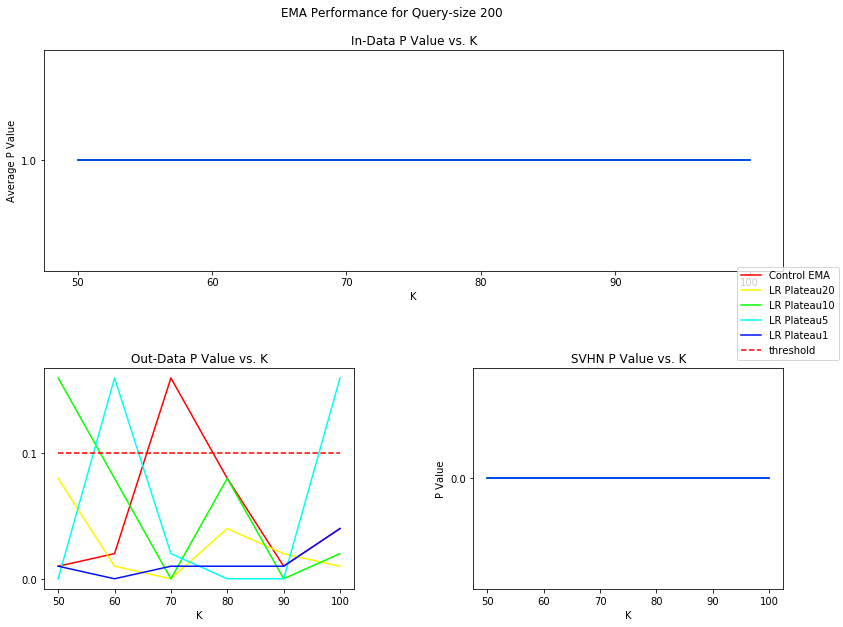

In [42]:
graph_200(tables_plateau, 200, 6)

In [4]:
### Run EMA on chest X-ray datasets, Table 3.b and Table 7
querydata = 'COVIDx'
expt = "l2"
epoch = 30

EMA_res_table = pd.DataFrame(columns=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CXR'], index=[f'k={100-k}' for k in klist])
for caldata in ['COVIDx']:
    for size in [800, 500, 200, 50, 20, 5]:
        print(f'-----  Query_size:{size} \t Cal data:{caldata}  -----')
        for mode in ['t']:
            print(f'Using {mode}-test')
            for k in klist:
                logname = f'caldata={caldata}_epoch={epoch}_k={k}_calsize=4000'
                for fold in range(7):
                    queryset = pd.read_csv(f'./saves_new/{expt}/EMA_{querydata}/query_set/binarized_{logname}_fold{fold}.csv')  

                    if fold == 0 or fold == 6:
                        ground_truth = 'Query is not in base'
                    else:
                        ground_truth = 'Query is in base'
                    t, pv = get_member_ratio(queryset[:size], skip=['modified entropy'], mode=mode)

                    EMA_res = np.around(pv, decimals=2)
                    if fold == 0:
                        EMA_res_table['CXR'][f'k={100-k}'] = EMA_res
                    else:
                        EMA_res_table[f'C{fold}'][f'k={100-k}'] = EMA_res

            print(EMA_res_table, '\n')
            EMA_res_table = pd.DataFrame(columns=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CXR'], index=[f'k={100-k}' for k in klist])

-----  Query_size:800 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5   C6  CXR
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5   C6  CXR
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5   C6  CXR
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5    C6   CXR
k=100  1  1  1  1  1  0.01  0.04
k=90   1  1  1  1  1   0.0   0.0
k=80 